# Андреев Алексей ИУ5-23М

#### Описание датасета
> Датасет с данными о прокате велосипедов в Лондоне.

Данные в датасете представляют информацию о погодных условиях, дате/времени и количестве велосипедов взятых на прокат в Лондоне за несколько лет

#### Описание колонок
Год — год, когда велосипед взят в аренду.

Месяц — месяц, когда велосипед взят в аренду.

День — день, когда велосипед взят в аренду.

Время — время в часах, когда велосипед взят в аренду.

Количество велосипедов — количество велосипедов, которые были взяты напрокат.

Температура воздуха  — температура воздуха в градусах Цельсия.

Ощущаемая температура — температура воздуха, ощущаемую человеком в градусах Цельсия.

Влажность воздуха — текущую влажность воздуха, выраженную в процентах.

Скорость ветра — скорость ветра в километрах в час.

Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана

Выбранный день - праздничный — 1 если праздничный день.

Выбранный день день - 1 если выходной.

Время года — 0-весна; 1-лето; 2-осень; 3-зима.


In [1]:
import random
from pprint import pprint

import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("london_merged.csv")
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [3]:
pprint({
    name: { 'type': type, 'nans': nans}
    for name, type, nans
    in zip(
        [i for i in data.columns],
        [str(i) for i in data.dtypes],
        [i for i in data.isnull().sum()]
    )
})

{'cnt': {'nans': 0, 'type': 'int64'},
 'hum': {'nans': 0, 'type': 'float64'},
 'is_holiday': {'nans': 0, 'type': 'float64'},
 'is_weekend': {'nans': 0, 'type': 'float64'},
 'season': {'nans': 0, 'type': 'float64'},
 't1': {'nans': 0, 'type': 'float64'},
 't2': {'nans': 0, 'type': 'float64'},
 'timestamp': {'nans': 0, 'type': 'object'},
 'weather_code': {'nans': 0, 'type': 'float64'},
 'wind_speed': {'nans': 0, 'type': 'float64'}}


In [4]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

# Масштабирование 
Тремя способами

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

data_scale = data.copy()
del data_scale['cnt']
del data_scale['is_holiday']
del data_scale['is_weekend']
del data_scale['season']
del data_scale['weather_code']
del data_scale['timestamp']
data_scale.describe()

# Влажность имеет слишком большие значения по сравнению с остальными признакамы. Поэтому нужно её отмасштабировать.

,t1,t2,hum,wind_speed
count,17414.000000,17414.000000,17414.000000,17414.000000
mean,12.468091,11.520836,72.324954,15.913063
std,5.571818,6.615145,14.313186,7.894570
min,-1.500000,-6.000000,20.500000,0.000000
25%,8.000000,6.000000,63.000000,10.000000
50%,12.500000,12.500000,74.500000,15.000000
75%,16.000000,16.000000,83.000000,20.500000
max,34.000000,34.000000,100.000000,56.500000


In [6]:
# Функция для восстановления датафрейма
# на основе масштабированных данных
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=data_scale.columns)
    return res

# Масштабирование данных на основе Z-оценки
# x′=(x−μ(x))/σ(x)
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(data_scale)

# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,t1,t2,hum,wind_speed
0,-1.699331,-1.439290,1.444517,-1.255717
1,-1.699331,-1.363703,1.444517,-1.382390
2,-1.789071,-1.363703,1.689054,-2.015755
3,-1.878811,-1.439290,1.933590,-2.015755
4,-1.878811,-1.741635,1.444517,-1.192381
...,...,...,...,...
17409,-1.340371,-1.590462,0.606105,0.391031
17410,-1.340371,-1.590462,0.606105,0.644377
17411,-1.250632,-1.514876,0.431436,1.024396
17412,-1.250632,-1.514876,0.256767,0.897723


In [7]:
data_cs11_scaled.describe()

,t1,t2,hum,wind_speed
count,1.741400e+04,1.741400e+04,1.741400e+04,1.741400e+04
mean,4.613246e-15,9.401767e-16,-1.195858e-15,-7.022444e-16
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.506990e+00,-2.648671e+00,-3.620888e+00,-2.015755e+00
25%,-8.019321e-01,-8.345992e-01,-6.515127e-01,-7.490253e-01
50%,5.727055e-03,1.480228e-01,1.519654e-01,-1.156604e-01
75%,6.339064e-01,6.771270e-01,7.458404e-01,5.810409e-01
max,3.864543e+00,3.398234e+00,1.933590e+00,5.141268e+00


In [8]:
# Масштабирование "Mean Normalisation"
# x′=(x−μ(x))/(max(x)−min(x))
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = param_df.mean(axis=0)
        maxs = param_df.max(axis=0)
        mins = param_df.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [9]:
sc21 = MeanNormalisation()

data_scale = data.copy()
del data_scale['cnt']
del data_scale['is_holiday']
del data_scale['is_weekend']
del data_scale['season']
del data_scale['weather_code']
del data_scale['timestamp']

data_cs21_scaled = sc21.fit_transform(data_scale)
data_cs21_scaled.describe()

,t1,t2,hum,wind_speed
count,1.741400e+04,1.741400e+04,1.741400e+04,1.741400e+04
mean,2.053074e-16,1.327802e-15,-3.191963e-16,-1.845330e-16
std,1.569526e-01,1.653786e-01,1.800401e-01,1.397269e-01
min,-3.934673e-01,-4.380209e-01,-6.518862e-01,-2.816471e-01
25%,-1.258617e-01,-1.380209e-01,-1.172950e-01,-1.046560e-01
50%,8.988505e-04,2.447911e-02,2.735907e-02,-1.616041e-02
75%,9.949040e-02,1.119791e-01,1.342773e-01,8.118472e-02
max,6.065327e-01,5.619791e-01,3.481138e-01,7.183529e-01


In [10]:
# MinMax-масштабирование
# x′=(x−min(x))/(max(x)−min(x))

# Обучаем StandardScaler на всей выборке и масштабируем
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(data_scale)
# формируем DataFrame на основе массива
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)
data_cs31_scaled.describe()

,t1,t2,hum,wind_speed
count,17414.000000,17414.000000,17414.000000,17414.000000
mean,0.393467,0.438021,0.651886,0.281647
std,0.156953,0.165379,0.180040,0.139727
min,0.000000,0.000000,0.000000,0.000000
25%,0.267606,0.300000,0.534591,0.176991
50%,0.394366,0.462500,0.679245,0.265487
75%,0.492958,0.550000,0.786164,0.362832
max,1.000000,1.000000,1.000000,1.000000


# Обработка выбросов числовых признаков

2 способа:
Удаление и замена

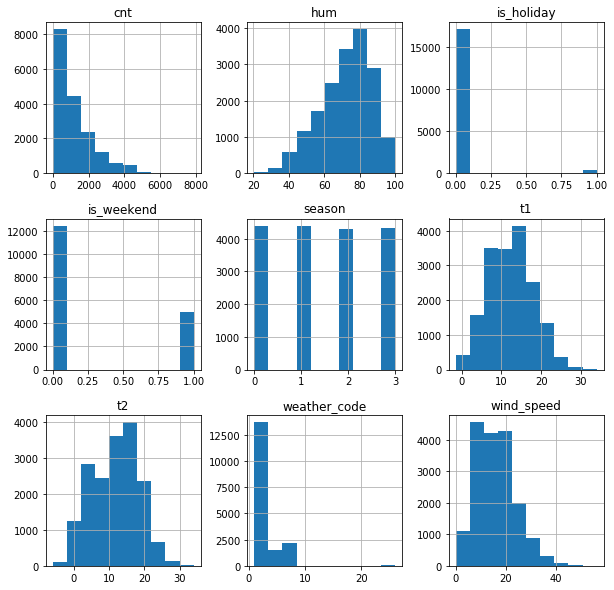

In [11]:
data.hist(figsize=(10,10));

In [12]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

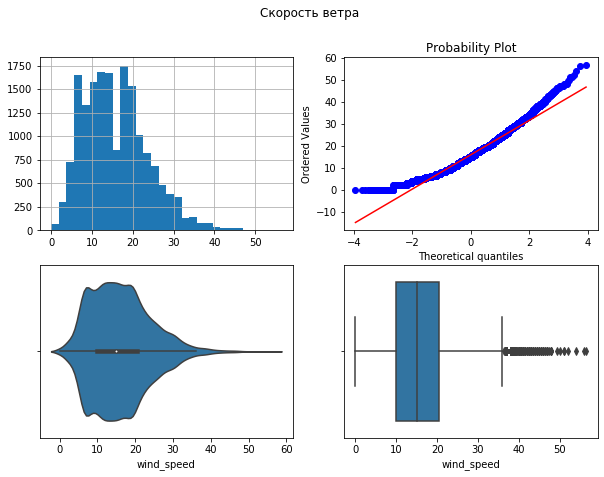

In [13]:
diagnostic_plots(data, 'wind_speed', 'Скорость ветра')

In [14]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary 

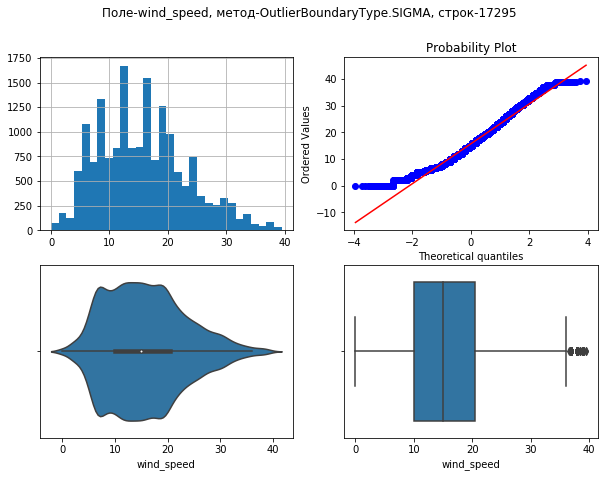

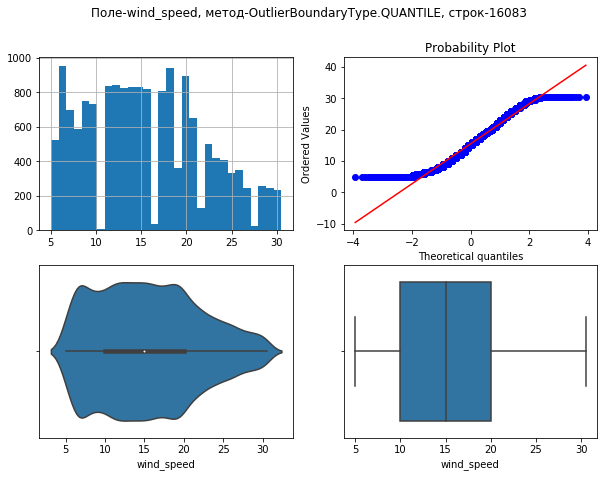

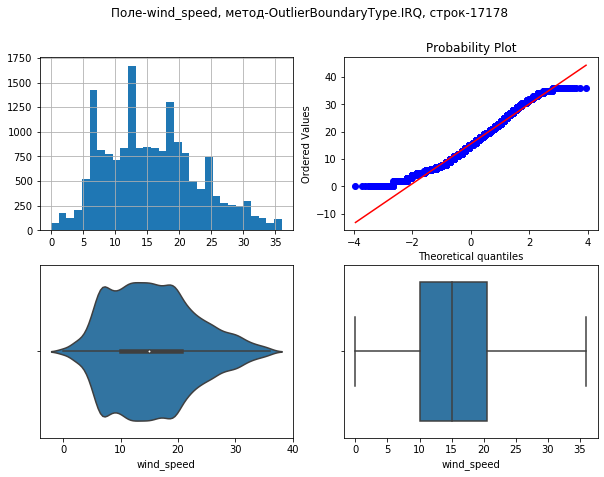

In [15]:
# удаление выбросов
x_col_list = ['wind_speed']
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data[col] > upper_boundary, True, 
                                 np.where(data[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

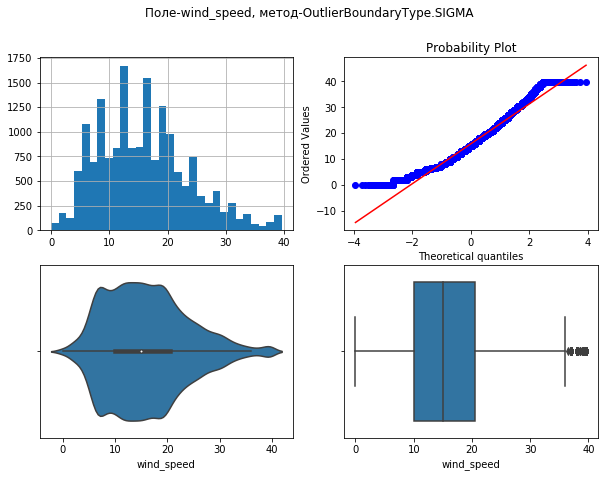

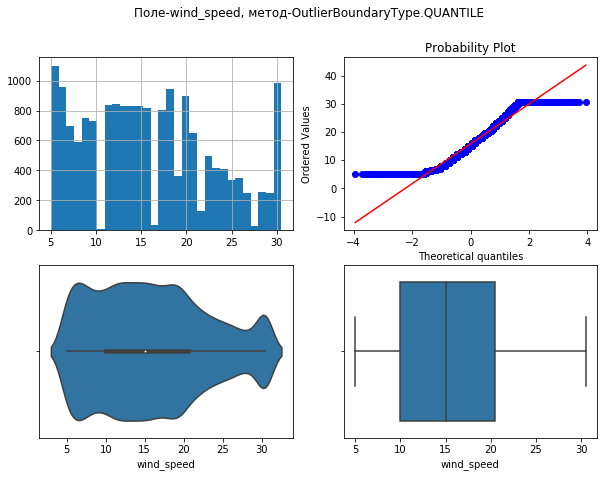

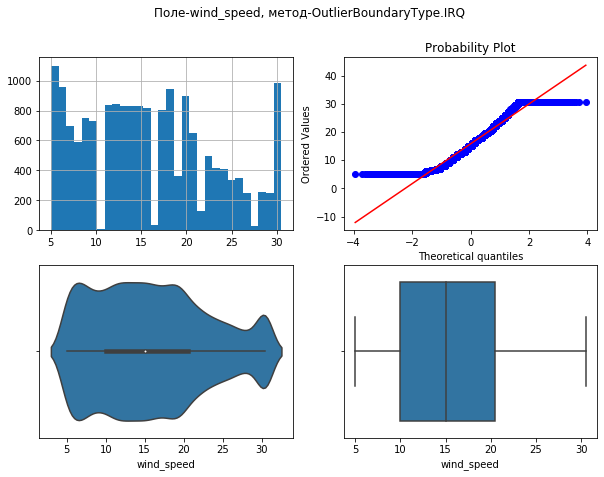

In [16]:
# Замена выбросов
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Изменение данных
        data[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                                 np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data, col, title)

# Обработка нестандартного признака

In [17]:
data['year'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).year))
data['month'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).month))
data['day'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).day))
data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))

del data['timestamp']
data

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1
2,134,2.5,2.5,96.5,5.0,1.0,0.0,1.0,3.0,2015,1,4,2
3,72,2.0,2.0,100.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,3
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,3,19
17410,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,3,20
17411,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,3,21
17412,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017,1,3,22


# Отбор признаков

один метод из группы методов фильтрации (filter methods);   
один метод из группы методов обертывания (wrapper methods);   
один метод из группы методов вложений (embedded methods).   

In [19]:
# filter methods
from sklearn.feature_selection import VarianceThreshold

selector_1211 = VarianceThreshold(threshold=0.15)
selector_1211.fit(data)
# Значения дисперсий для каждого признака
selector_1211.variances_


array([1.17739190e+06, 3.10433682e+01, 4.37576261e+01, 2.04855532e+02,
       5.22529227e+01, 5.48073078e+00, 2.15649667e-02, 2.03947934e-01,
       1.25188965e+00, 2.58208216e-01, 1.19191321e+01, 7.73247850e+01,
       4.78268310e+01])

Отсюда следует, что Год (year), Сезон (season), Выходные (is_weekend), Праздники (is_holiday) имеют очень маленькую дисперсию, а значит слабо могут повлиять на целевой признак.

In [20]:
data

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1
2,134,2.5,2.5,96.5,5.0,1.0,0.0,1.0,3.0,2015,1,4,2
3,72,2.0,2.0,100.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,3
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,3,19
17410,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,3,20
17411,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,3,21
17412,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017,1,3,22


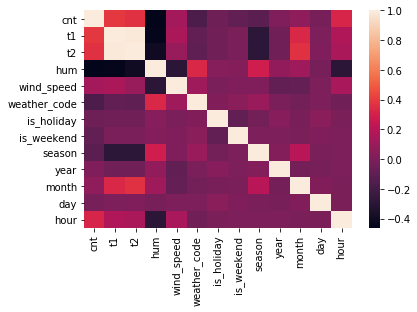

In [21]:
# Метод основанный на корреляции
sns.heatmap(data.corr())

In [23]:
# Формирование DataFrame с корреляциями больше половины
def make_corr_df(df):
    cr = data.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.4]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

make_corr_df(data)

,f1,f2,corr
0,t2,t1,0.988344
1,t1,t2,0.988344
2,cnt,hum,0.462901
3,hum,cnt,0.462901
4,hum,t1,0.447781
5,t1,hum,0.447781
6,hum,t2,0.403495
7,t2,hum,0.403495


In [24]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [25]:
corr_groups(make_corr_df(data))

[['t1', 'hum', 't2'], ['hum', 'cnt']]

In [30]:
# wrapper methods (sequential forward selection).

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

X = data.drop(columns = ['year','t2','season','cnt','year', 'day', 'wind_speed'])
y = data['cnt']

feature_names = [i for i in X.columns]
feature_names

['t1', 'hum', 'weather_code', 'is_holiday', 'is_weekend', 'month', 'hour']

In [31]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.6s finished

[2021-06-20 15:56:58] Features: 1/3 -- score: 0.008958309406224876[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s finished

[2021-06-20 15:57:01] Features: 2/3 -- score: 0.10721258757321696[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished

[2021-06-20 15:57:04] Features: 3/3 -- score: 0.2920064316067532

In [32]:
sfs1.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([0.00895831]),
  'avg_score': 0.008958309406224876,
  'feature_names': ('hum',)},
 2: {'feature_idx': (1, 6),
  'cv_scores': array([0.10721259]),
  'avg_score': 0.10721258757321696,
  'feature_names': ('hum', 'hour')},
 3: {'feature_idx': (0, 1, 6),
  'cv_scores': array([0.29200643]),
  'avg_score': 0.2920064316067532,
  'feature_names': ('t1', 'hum', 'hour')}}

In [33]:
# embedded methods

X = data.drop(columns = ['year','t2','season','cnt','year', 'day', 'wind_speed'])
y = data['cnt']

# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)

In [34]:
feature_names = [i for i in X.columns]
feature_names

['t1', 'hum', 'weather_code', 'is_holiday', 'is_weekend', 'month', 'hour']

In [35]:
# L1-регуляризация
e_ls1 = Lasso(random_state=1)
e_ls1.fit(X, y)

# Коэффициенты регрессии
list(zip(feature_names, e_ls1.coef_))

[('t1', 40.25432783035468),
 ('hum', -22.736644547093288),
 ('weather_code', -15.020866943240419),
 ('is_holiday', -255.30062673342667),
 ('is_weekend', -209.15178832966413),
 ('month', 8.413775369314772),
 ('hour', 31.309632231240386)]

In [36]:
sel_e_ls1 = SelectFromModel(e_ls1)
sel_e_ls1.fit(X, y)
list(zip(feature_names, sel_e_ls1.get_support()))

[('t1', True),
 ('hum', True),
 ('weather_code', True),
 ('is_holiday', True),
 ('is_weekend', True),
 ('month', True),
 ('hour', True)]